In [53]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import shap
from shap import maskers
import kagglehub


In [34]:
# Download dataset
dataset_path = kagglehub.dataset_download("ninadaithal/imagesoasis")
print("Dataset downloaded to:", dataset_path)
data_dir = os.path.join(dataset_path, "Data")

Dataset downloaded to: /home/helal/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1
Dataset downloaded to: /home/helal/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1


In [35]:
# Configuration
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
EPOCHS = 5

In [36]:
# Define 4-class mapping
CLASS_MAPPING = {
    "Non Demented": "CN",
    "Very mild Dementia": "MCI",
    "Mild Dementia": "Mild_AD",
    "Moderate Dementia": "Moderate_AD"
}

In [37]:
def preprocess_image(image):
    """Enhanced preprocessing for medical images"""
    # Convert to RGB if grayscale
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Apply unsharp masking with valid Gaussian blur
    blurred = cv2.GaussianBlur(image, (5, 5), 1.0)
    image = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    
    return image

In [38]:
# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    zoom_range=0.1,
    validation_split=0.2,
    preprocessing_function=preprocess_image
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [39]:
# Create generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(CLASS_MAPPING.keys())
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(CLASS_MAPPING.keys())
)

Found 69151 images belonging to 4 classes.
Found 17286 images belonging to 4 classes.


In [40]:
# Verify class indices
print("\nClass Indices:", train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())


Class Indices: {'Non Demented': 0, 'Very mild Dementia': 1, 'Mild Dementia': 2, 'Moderate Dementia': 3}


In [41]:
# Model Architecture
def create_model():
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.6),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    
    model.compile(
        optimizer=RMSprop(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,401,156 (81.64 MB)

 Trainable params: 6,686,468 (25.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [42]:
# Class weights
class_counts = {cls: sum(train_generator.classes == idx) 
               for cls, idx in train_generator.class_indices.items()}
total_samples = sum(class_counts.values())
class_weights = {
    idx: total_samples/(len(class_counts)*count) 
    for cls, (idx, count) in zip(class_counts.keys(), class_counts.items())
}
print("\nClass Weights:", class_weights)


Class Weights: {'Non Demented': np.float64(0.3214650972516642), 'Very mild Dementia': np.float64(1.574476320582878), 'Mild Dementia': np.float64(4.319777611194403), 'Moderate Dementia': np.float64(44.21419437340153)}


In [43]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=7),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
    ])

/home/helal/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


2025-05-04 04:23:44.798448: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=2,k3=0} for conv (f32[32,128,80,80]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,80,80]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-04 04:23:45.176083: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.380171386s
Trying algorithm eng11{k2=2,k3=0} for conv (f32[32,128,80,80]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,80,80]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationFor

2161/2161 ━━━━━━━━━━━━━━━━━━━━ 549s 245ms/step - accuracy: 0.7487 - loss: 0.7613 - val_accuracy: 0.7650 - val_loss: 0.6116 - learning_rate: 1.0000e-05
Epoch 2/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 438s 203ms/step - accuracy: 0.7763 - loss: 0.6045 - val_accuracy: 0.7632 - val_loss: 0.6035 - learning_rate: 1.0000e-05
Epoch 3/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 405s 188ms/step - accuracy: 0.7809 - loss: 0.5622 - val_accuracy: 0.7546 - val_loss: 0.6022 - learning_rate: 1.0000e-05
Epoch 4/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 413s 191ms/step - accuracy: 0.7843 - loss: 0.5403 - val_accuracy: 0.7597 - val_loss: 0.6082 - learning_rate: 1.0000e-05
Epoch 5/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 412s 190ms/step - accuracy: 0.7878 - loss: 0.5225 - val_accuracy: 0.7449 - val_loss: 0.6130 - learning_rate: 1.0000e-05


In [44]:
# Visualization functions (same as before)
def plot_history(history):
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(10, 5))
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Validation')
        plt.title(f'Model {metric.capitalize()}')
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        plt.legend()
    plt.tight_layout()
    plt.show()

In [45]:
def plot_roc_curve(y_true, y_score, class_names):
    """Plot ROC curves for each class"""
    # Binarize the output
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    colors = cycle(['blue', 'red', 'green', 'orange'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of {0} (AUC = {1:0.2f})'
                 ''.format(class_names[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [46]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', 
                    cbar=False, square=True, 
                    xticklabels=class_names, 
                    yticklabels=class_names)
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j+0.5, i+0.3, f"{cm[i, j]}", 
                   ha='center', va='center', color='black')
    plt.title('Confusion Matrix (%) with Counts', pad=20, fontsize=16)
    plt.xlabel('Predicted Label', labelpad=15)
    plt.ylabel('True Label', labelpad=15)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [65]:
def generate_shap_explanation(model, sample_image, train_generator, num_samples=50):

    # Expand dims for single sample
    sample_image = np.expand_dims(sample_image, axis=0)  # (1, H, W, 3)

    # Collect background images from generator
    background_images = []
    gen = iter(train_generator)
    while len(background_images) < num_samples:
        batch_images, _ = next(gen)
        background_images.extend(batch_images)
        if len(background_images) >= num_samples:
            break
    background_images = np.array(background_images[:num_samples])  # (num_samples, H, W, 3)

    # Initialize SHAP explainer
    explainer = shap.DeepExplainer(model, background_images)

    # Compute SHAP values
    shap_values = explainer.shap_values(sample_image)

    # Plot SHAP explanation
    shap.image_plot(shap_values, -sample_image, show=True)

In [48]:
def explain_with_lime(model, image, class_names, top_labels=4):
    explainer = lime_image.LimeImageExplainer()
    if image.max() > 1.0:
        image = image / 255.0
    explanation = explainer.explain_instance(
        image.astype('double'), 
        lambda x: model.predict(x, verbose=0),
        top_labels=top_labels,
        hide_color=0,
        num_samples=1000)
    fig, axes = plt.subplots(1, top_labels, figsize=(20, 5))
    if top_labels == 1:
        axes = [axes]
    for i, class_idx in enumerate(explanation.top_labels):
        temp, mask = explanation.get_image_and_mask(
            class_idx,
            positive_only=True,
            num_features=5,
            hide_rest=False)
        axes[i].imshow(mark_boundaries(temp, mask))
        axes[i].set_title(f"Explanation for {class_names[class_idx]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [66]:
def evaluate_model(model, generator):
    y_true = generator.classes
    y_prob = model.predict(generator)
    y_pred = np.argmax(y_prob, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    plot_roc_curve(y_true, y_prob, class_names)
    plot_confusion_matrix(y_true, y_pred, class_names)

    # SHAP: Show one image per class
    shown_classes = set()
    gen = iter(generator)
    print("\nSHAP explanations (one per class):")
    while len(shown_classes) < len(class_names):
        batch_images, batch_labels = next(gen)
        for img, label in zip(batch_images, batch_labels):
            class_idx = np.argmax(label)
            if class_idx not in shown_classes:
                print(f"SHAP for class: {class_names[class_idx]}")
                generate_shap_explanation(model, img, train_generator)
                shown_classes.add(class_idx)
            if len(shown_classes) == len(class_names):
                break

    # LIME explanations (optional, as before)
    sample_images, _ = next(generator)
    for i in range(min(3, len(sample_images))):
        print(f"\nExplanation for sample {i+1}:")
        explain_with_lime(model, sample_images[i], class_names)


Training History:


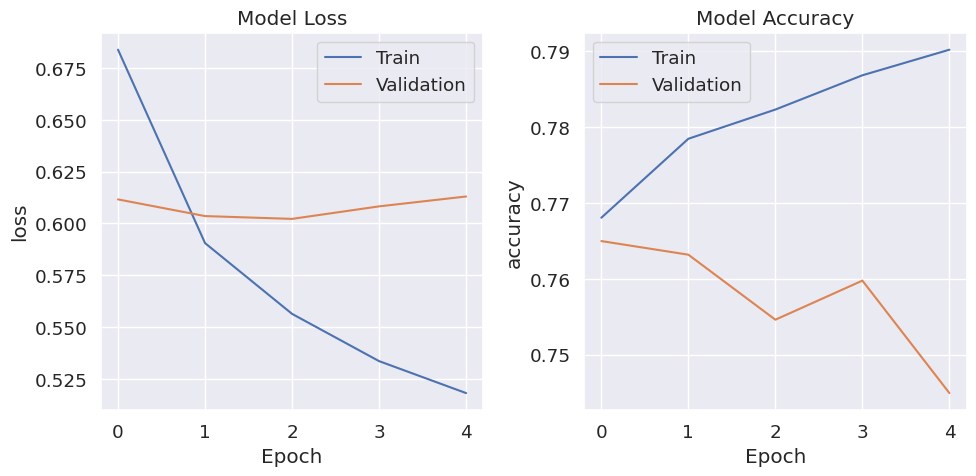


Validation Set Evaluation:
541/541 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step

Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.81      0.91      0.86     13444
Very mild Dementia       0.31      0.21      0.25      2745
     Mild Dementia       0.17      0.06      0.08      1000
 Moderate Dementia       0.00      0.00      0.00        97

          accuracy                           0.74     17286
         macro avg       0.32      0.29      0.30     17286
      weighted avg       0.69      0.74      0.71     17286



/home/helal/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helal/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helal/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


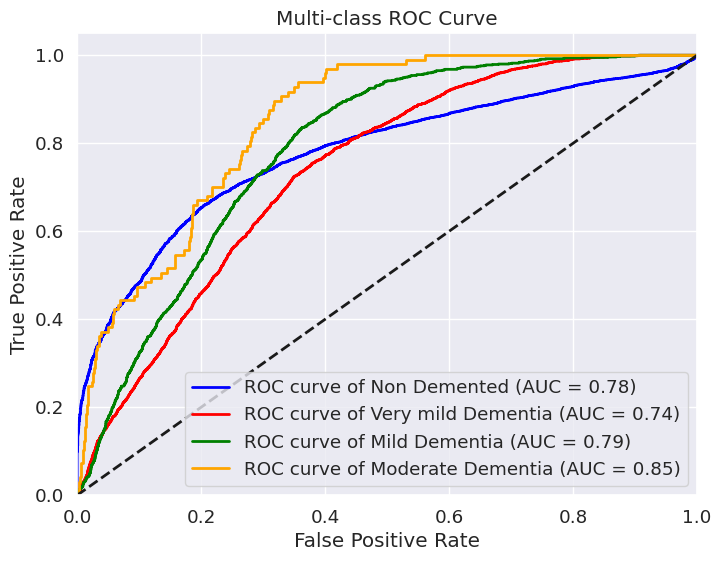

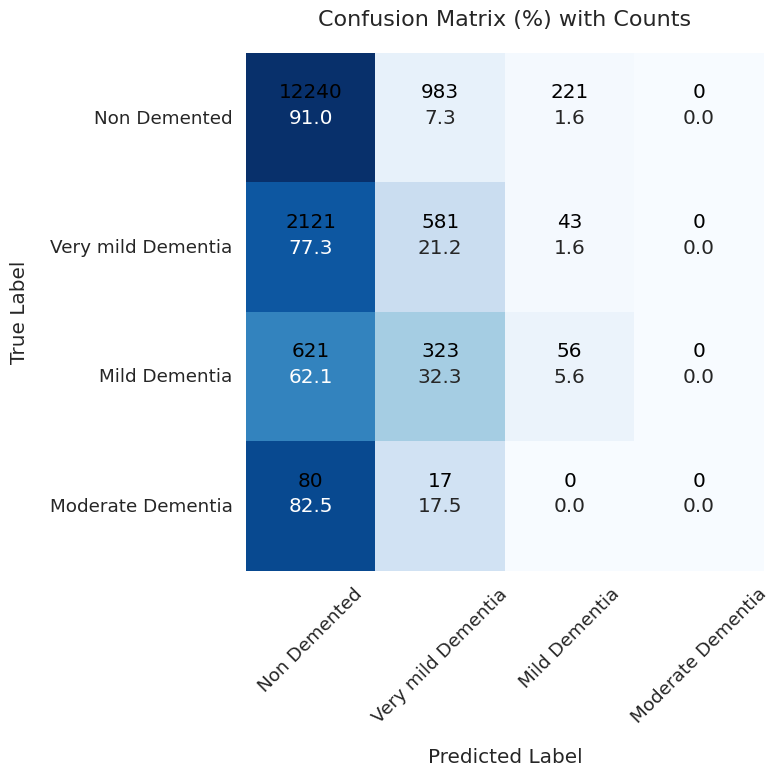


SHAP explanations (one per class):
SHAP for class: Very mild Dementia


/home/helal/tf-gpu/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/home/helal/tf-gpu/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_63
Received: inputs=['Tensor(shape=(50, 160, 160, 3))']
  warnings.warn(msg)
/home/helal/tf-gpu/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_63
Received: inputs=['Tensor(shape=(100, 160, 160, 3))']
  warnings.warn(msg)


: 

: 

: 

In [67]:
# Run evaluation
print("\nTraining History:")
plot_history(history)

print("\nValidation Set Evaluation:")
evaluate_model(model, val_generator)